In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =4.06197e-22

nband = 340

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 0

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6/

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

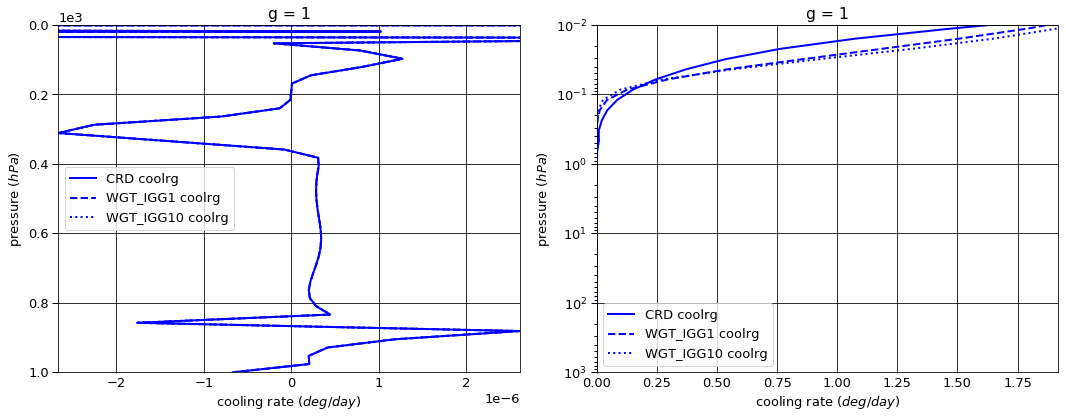

# Figure: cooling rate g-group 2

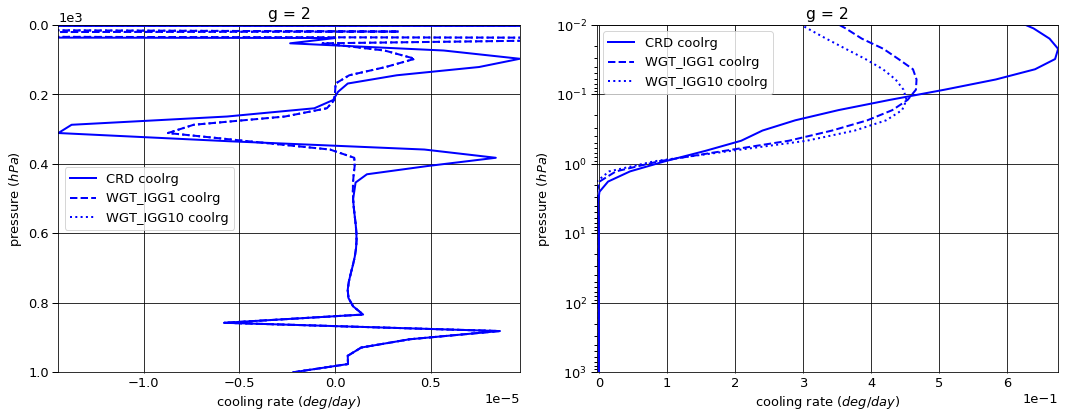

# Figure: cooling rate g-group 3

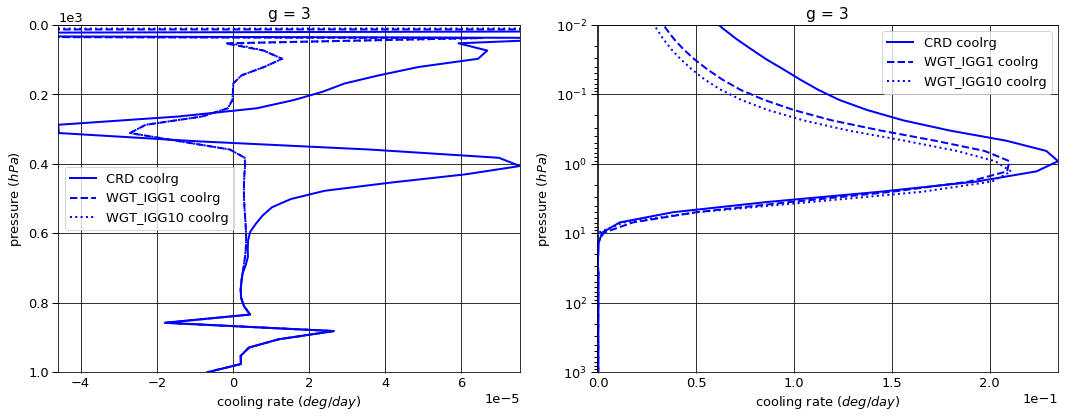

# Figure: cooling rate g-group 4

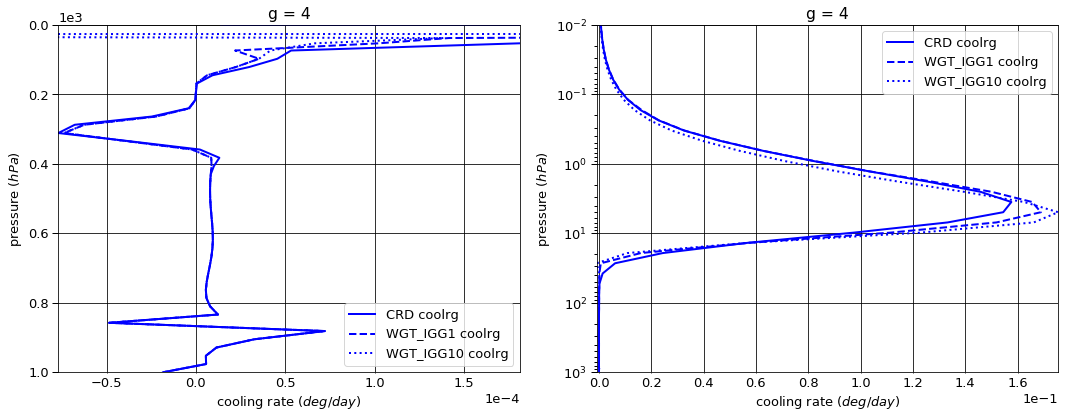

# Figure: cooling rate g-group 5

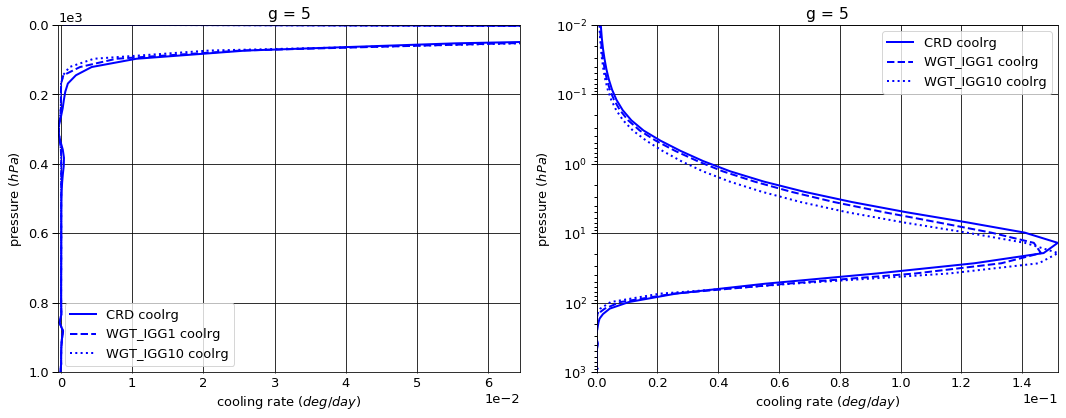

# Figure: cooling rate g-group 6

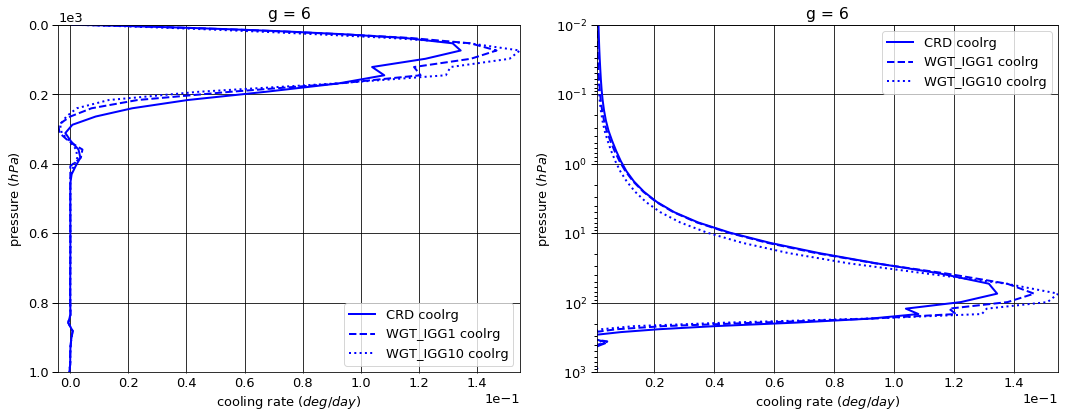

# Figure: cooling rate g-group 7

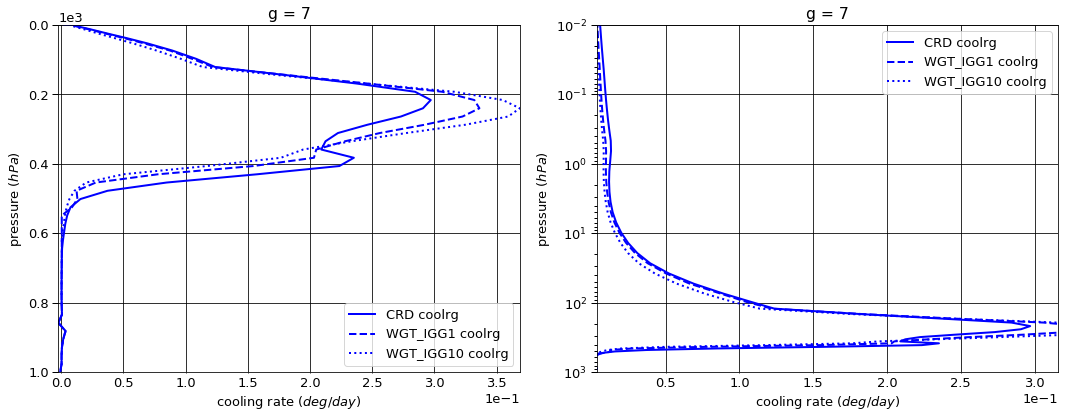

# Figure: cooling rate g-group 8

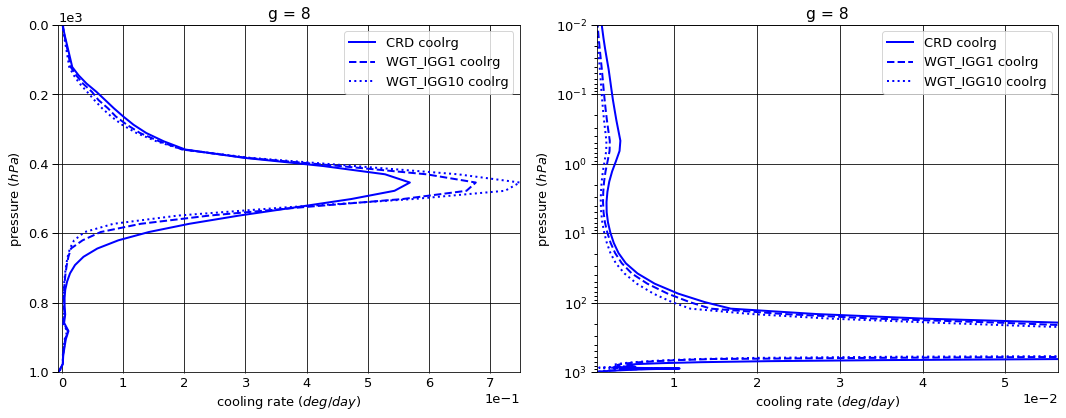

# Figure: cooling rate g-group 9

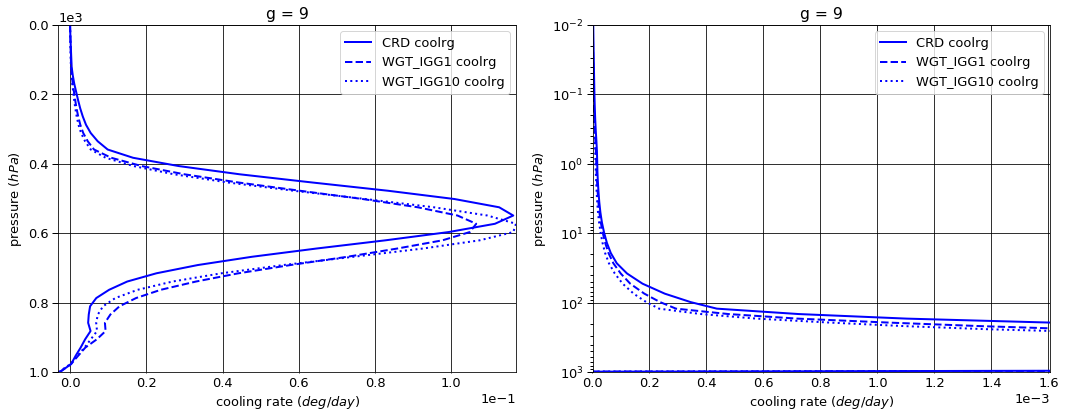

# Figure: cooling rate g-group total

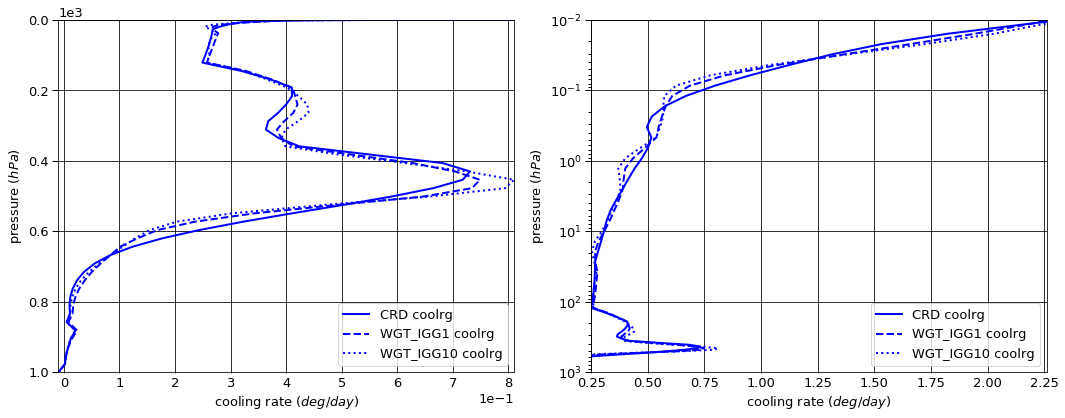

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008680   0.000000  -0.008680
  1013.0   76     -0.010222   0.010224   0.000002
2 0.0      1      -0.031447   0.000000  -0.031447
  1013.0   76     -0.033009   0.033016   0.000008
3 0.0      1      -0.089709   0.000000  -0.089709
  1013.0   76     -0.103470   0.103493   0.000023
4 0.0      1      -0.221582   0.000000  -0.221582
  1013.0   76     -0.287648   0.287711   0.000063
5 0.0      1      -0.851969   0.000000  -0.851969
  1013.0   76     -1.169379   1.169639   0.000260
6 0.0      1      -2.677371   0.000000  -2.677371
  1013.0   76     -3.637707   3.638509   0.000801
7 0.0      1     -10.333014   0.000000 -10.333014
  1013.0   76    -13.656538  13.659633   0.003095
8 0.0      1     -14.589404   0.000000 -14.589404
  1013.0   76    -17.757357  17.780047   0.022689
9 0.0      1      -3.158606   0.000000  -3.158606
  1013.0   76     -3.623220   3.636479   0.013260


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008757   0.000000  -0.008757
  1013.0   76     -0.010222   0.010224   0.000002
2 0.0      1      -0.031965   0.000000  -0.031965
  1013.0   76     -0.033009   0.033016   0.000008
3 0.0      1      -0.088885   0.000000  -0.088885
  1013.0   76     -0.103470   0.103493   0.000023
4 0.0      1      -0.222607   0.000000  -0.222607
  1013.0   76     -0.287648   0.287711   0.000063
5 0.0      1      -0.850098   0.000000  -0.850098
  1013.0   76     -1.169379   1.169638   0.000259
6 0.0      1      -2.675731   0.000000  -2.675731
  1013.0   76     -3.637707   3.638509   0.000801
7 0.0      1     -10.240001   0.000000 -10.240001
  1013.0   76    -13.656538  13.659583   0.003045
8 0.0      1     -14.485232   0.000000 -14.485232
  1013.0   76    -17.757357  17.776750   0.019392
9 0.0      1      -3.234980   0.000000  -3.234980
  1013.0   76     -3.623220   3.643476   0.020256


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008755   0.000000  -0.008755
  1013.0   76     -0.010222   0.010224   0.000002
2 0.0      1      -0.032094   0.000000  -0.032094
  1013.0   76     -0.033009   0.033016   0.000008
3 0.0      1      -0.088947   0.000000  -0.088947
  1013.0   76     -0.103470   0.103493   0.000023
4 0.0      1      -0.222327   0.000000  -0.222327
  1013.0   76     -0.287648   0.287711   0.000063
5 0.0      1      -0.848327   0.000000  -0.848327
  1013.0   76     -1.169379   1.169638   0.000259
6 0.0      1      -2.676117   0.000000  -2.676117
  1013.0   76     -3.637707   3.638509   0.000801
7 0.0      1     -10.211760   0.000000 -10.211760
  1013.0   76    -13.656538  13.659583   0.003045
8 0.0      1     -14.475755   0.000000 -14.475755
  1013.0   76    -17.757357  17.773032   0.015675
9 0.0      1      -3.233696   0.000000  -3.233696
  1013.0   76     -3.623220   3.642756   0.019537


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -7.731200e-05  0.000000e+00 -7.731200e-05
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -5.174180e-04  0.000000e+00 -5.174180e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3 0.0      1      8.237970e-04  0.000000e+00  8.237970e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4 0.0      1     -1.025660e-03  0.000000e+00 -1.025660e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      1.871200e-03  0.000000e+00  1.871200e-03
  1013.0   76     0.000000e+00 -9.000000e-07 -9.333300e-07
6 0.0      1      1.639800e-03  0.000000e+00  1.639800e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7 0.0      1      9.301300e-02  0.000000e+00  9.301300e-02
  1013.0   76     1.776357e-15 -5.000000e-05 -4.957240e-05
8 0.0      1      1.041720e-01  0.000000e+00  1.041720e-01
  1013.0   76     0.000000e+00 -3.297000e-03 -3.297257e-03
9 0.0      1     -7.637400e-02  0.000000e+00 -7.637400e-02
  1013.0   76    -4.440892e-16  6.996600e-03  6.996564e-03


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -7.538400e-05  0.000000e+00 -7.538400e-05
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -6.469760e-04  0.000000e+00 -6.469760e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3 0.0      1      7.622490e-04  0.000000e+00  7.622490e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4 0.0      1     -7.450500e-04  0.000000e+00 -7.450500e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      3.642180e-03  0.000000e+00  3.642180e-03
  1013.0   76     0.000000e+00 -9.000000e-07 -9.333300e-07
6 0.0      1      1.254300e-03  0.000000e+00  1.254300e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7 0.0      1      1.212540e-01  0.000000e+00  1.212540e-01
  1013.0   76     1.776357e-15 -5.000000e-05 -4.957240e-05
8 0.0      1      1.136490e-01  0.000000e+00  1.136490e-01
  1013.0   76     0.000000e+00 -7.015000e-03 -7.014685e-03
9 0.0      1     -7.508950e-02  0.000000e+00 -7.508950e-02
  1013.0   76    -4.440892e-16  6.276900e-03  6.276914e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      4.319146e+00
  1001.112500 75    -6.667177e-07
2 0.000312    1      2.981983e-01
  1001.112500 75    -2.194682e-06
3 0.000312    1      2.713347e-02
  1001.112500 75    -6.778754e-06
4 0.000312    1      1.552541e-05
  1001.112500 75    -1.841094e-05
5 0.000312    1      4.375255e-04
  1001.112500 75    -7.557567e-05
6 0.000312    1      8.214901e-04
  1001.112500 75    -2.327487e-04
7 0.000312    1      2.982209e-03
  1001.112500 75    -8.970900e-04
8 0.000312    1      4.946181e-04
  1001.112500 75    -5.856687e-03
9 0.000312    1      9.644587e-07
  1001.112500 75    -2.744851e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.248123e+00
  1001.112500 75    -6.667177e-07
2 0.000312    1      1.622747e-01
  1001.112500 75    -2.194682e-06
3 0.000312    1      1.521113e-02
  1001.112500 75    -6.778754e-06
4 0.000312    1      1.580664e-05
  1001.112500 75    -1.841094e-05
5 0.000312    1      3.583192e-04
  1001.112500 75    -7.532092e-05
6 0.000312    1      4.578503e-04
  1001.112500 75    -2.327487e-04
7 0.000312    1      2.026748e-03
  1001.112500 75    -8.843541e-04
8 0.000312    1      3.151148e-04
  1001.112500 75    -5.524041e-03
9 0.000312    1      5.308624e-07
  1001.112500 75    -2.839858e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.863063e+00
  1001.112500 75    -6.667177e-07
2 0.000312    1      1.306009e-01
  1001.112500 75    -2.194682e-06
3 0.000312    1      1.327295e-02
  1001.112500 75    -6.778754e-06
4 0.000312    1      1.363925e-05
  1001.112500 75    -1.841094e-05
5 0.000312    1      3.028215e-04
  1001.112500 75    -7.532092e-05
6 0.000312    1      3.807253e-04
  1001.112500 75    -2.327487e-04
7 0.000312    1      1.682501e-03
  1001.112500 75    -8.843541e-04
8 0.000312    1      2.538127e-04
  1001.112500 75    -4.499143e-03
9 0.000312    1      4.179017e-07
  1001.112500 75    -3.062227e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.071023e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.359236e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.192234e-02
  1001.112500 75     0.000000e+00
4 0.000312    1      2.812310e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -7.920630e-05
  1001.112500 75     2.547570e-07
6 0.000312    1     -3.636398e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -9.554605e-04
  1001.112500 75     1.273583e-05
8 0.000312    1     -1.795033e-04
  1001.112500 75     3.326463e-04
9 0.000312    1     -4.335964e-07
  1001.112500 75    -9.500740e-05


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.456083e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.675974e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.386052e-02
  1001.112500 75     0.000000e+00
4 0.000312    1     -1.886154e-06
  1001.112500 75     0.000000e+00
5 0.000312    1     -1.347039e-04
  1001.112500 75     2.547570e-07
6 0.000312    1     -4.407648e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -1.299708e-03
  1001.112500 75     1.273583e-05
8 0.000312    1     -2.408054e-04
  1001.112500 75     1.357544e-03
9 0.000312    1     -5.465570e-07
  1001.112500 75    -3.173762e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.961782,0.000000,-31.961782
1013.0,76,-40.278549,40.318752,0.040202



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.838256,0.000000,-31.838256
1013.0,76,-40.278549,40.322401,0.043851



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.797777,0.000000,-31.797777
1013.0,76,-40.278549,40.317963,0.039414



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.235254e-01,0.000000,0.123525
1013.0,76,7.105427e-15,0.003649,0.003649



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.640048e-01,0.000000,0.164005
1013.0,76,7.105427e-15,-0.000789,-0.000788


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.649231
1001.112500,75,-0.009835



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.428783
1001.112500,75,-0.009584



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.009571
1001.112500,75,-0.008782



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.220447
1001.112500,75,0.000251



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.639660
1001.112500,75,0.001053


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000294,0.000255
2,0.000824,0.000821
3,0.002676,0.002575
4,0.008059,0.007167
5,0.032191,0.029128
6,0.102588,0.090650
7,0.370279,0.340090
8,0.369897,0.440079
9,0.113191,0.089236


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.222796e-17
2,5.686282e-18
3,4.476633e-19
4,1.008726e-18
5,8.035412e-20
6,6.291501e-20
7,5.056287e-21
8,4.063584e-22
9,2.611776e-24


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.222796e-17,NaN,0.000294,0.000255,0.000294,0.000255,1.0
2,5.686282e-18,0.078727,0.000824,0.000821,0.001118,0.001075,1.0
3,4.476633e-19,0.078727,0.002676,0.002575,0.003794,0.003650,1.0
4,1.008726e-18,2.253314,0.008059,0.007167,0.011853,0.010817,30.0
5,8.035412e-20,0.079659,0.032191,0.029128,0.044044,0.039945,30.0
6,6.291501e-20,0.782972,0.102588,0.090650,0.146632,0.130595,300.0
7,5.056287e-21,0.080367,0.370279,0.340090,0.516912,0.470685,300.0
8,4.063584e-22,0.080367,0.369897,0.440079,0.886809,0.910764,300.0
9,2.611776e-24,0.006427,0.113191,0.089236,1.000000,1.000000,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.407741e-16  1.087196e-16   3.134431  1.518729e-02
      2 0.000312     8.801156e-18  3.286015e-18   2.678367  4.207435e-04
      3 0.000312     2.499409e-19  7.045556e-20   3.547497  1.058563e-05
      4 0.000312     3.882481e-23  3.882404e-23   1.000020  3.306320e-09
      5 0.000312     2.652817e-22  1.696517e-22   1.563684  1.689092e-08
      6 0.000312     1.535764e-22  4.981619e-23   3.082861  6.893305e-09
      7 0.000312     1.536960e-22  1.443001e-23  10.651135  8.344908e-09
      8 0.000312     2.242227e-23  1.132640e-24  19.796463  1.184287e-09
      9 0.000312     2.479462e-25  1.142059e-26  21.710447  1.305826e-11
2     1 0.000750     3.434194e-16  1.096206e-16   3.132799  6.166096e-03
      2 0.000750     9.032479e-18  3.331860e-18   2.710942  1.729511e-04
      3 0.000750     2.544554e-19  7.214570e-20   3.526966  4.350789e-06
      4 0.000750     9.235767e-23  9.235434e-23   1.000036  3.167952e-09
      5 0.000750     2.773945e-22  1.789585e-22   1.550049  7.151555e-09
      6 0.000750     1.545261e-22  5.090336e-23   3.035676  2.812409e-09
      7 0.000750     1.556365e-22  1.466227e-23  10.614764  3.404342e-09
      8 0.000750     2.311040e-23  1.154880e-24  20.011080  4.914824e-10
      9 0.000750     2.586788e-25  1.213939e-26  21.309035  5.490446e-12
3     1 0.001052     3.486965e-16  1.113399e-16   3.131819  8.781295e-03
      2 0.001052     9.507955e-18  3.415071e-18   2.784116  2.522079e-04
      3 0.001052     2.633556e-19  7.480041e-20   3.520777  6.319318e-06
      4 0.001052     1.295688e-22  1.295625e-22   1.000048  6.232608e-09
      5 0.001052     2.968589e-22  1.919949e-22   1.546181  1.074911e-08
      6 0.001052     1.561328e-22  5.271958e-23   2.961571  4.028426e-09
      7 0.001052     1.597460e-22  1.507427e-23  10.597261  4.900739e-09
      8 0.001052     2.457149e-23  1.194841e-24  20.564649  7.321876e-10
      9 0.001052     2.810535e-25  1.310327e-26  21.449104  8.364061e-12
4     1 0.001476     3.539555e-16  1.131003e-16   3.129573  1.250884e-02
      2 0.001476     1.000959e-17  3.500025e-18   2.859861  3.679894e-04
      3 0.001476     2.731511e-19  7.764000e-20   3.518175  9.197778e-06
      4 0.001476     1.818557e-22  1.818438e-22   1.000065  1.227200e-08
      5 0.001476     3.195917e-22  2.069213e-22   1.544509  1.624519e-08
      6 0.001476     1.579962e-22  5.474408e-23   2.886087  5.784809e-09
      7 0.001476     1.642823e-22  1.550737e-23  10.593821  7.070575e-09
      8 0.001476     2.616437e-23  1.237187e-24  21.148274  1.092821e-09
      9 0.001476     3.055457e-25  1.422682e-26  21.476739  1.275592e-11
5     1 0.002070     3.591224e-16  1.148862e-16   3.125897  1.780978e-02
      2 0.002070     1.053218e-17  3.586348e-18   2.936743  5.366963e-04
      3 0.002070     2.838401e-19  8.069929e-20   3.517256  1.340691e-05
      4 0.002070     2.553302e-22  2.553075e-22   1.000089  2.416647e-08
      5 0.002070     3.461342e-22  2.241143e-22   1.544454  2.467817e-08
      6 0.002070     1.601519e-22  5.699968e-23   2.809699  8.324362e-09
      7 0.002070     1.692350e-22  1.596176e-23  10.602528  1.021558e-08
      8 0.002070     2.788202e-23  1.282031e-24  21.748328  1.632023e-09
      9 0.002070     3.320540e-25  1.554659e-26  21.358631  1.944672e-11
6     1 0.002904     3.641901e-16  1.167058e-16   3.120582  2.535343e-02
      2 0.002904     1.107653e-17  3.674948e-18   3.014063  7.827615e-04
      3 0.002904     2.955491e-19  8.406928e-20   3.515542  1.958599e-05
      4 0.002904     3.585844e-22  3.585409e-22   1.000121  4.760681e-08
      5 0.002904     3.774654e-22  2.442867e-22   1.545174  3.773985e-08
      6 0.002904     1.626684e-22  5.954450e-23   2.731879  1.201365e-08
      7 0.002904     1.746484e-22  1.644469e-23  10.620353  1.478668e-08
      8 0.002904     2.973623e-23  1.330120e-24  22.356051  2.439570e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
